In [2]:
import sys               
import time              
import pickle     
import numpy as np
import pandas as pd
import skimage.measure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import xgboost as xgb

from matplotlib import pyplot as plt
import seaborn as sb
from PIL import Image
from IPython.display import HTML, display
import tabulate

%matplotlib inline

v = sb.__version__
print(v)

0.11.2


In [3]:
df = pd.read_csv('../Dataset/BrainTumor.csv')
nbr_images = df.shape[0]
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.460000e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.460000e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.460000e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.460000e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.460000e-155


In [4]:
print('Total number of images:', nbr_images)

Total number of images: 3762


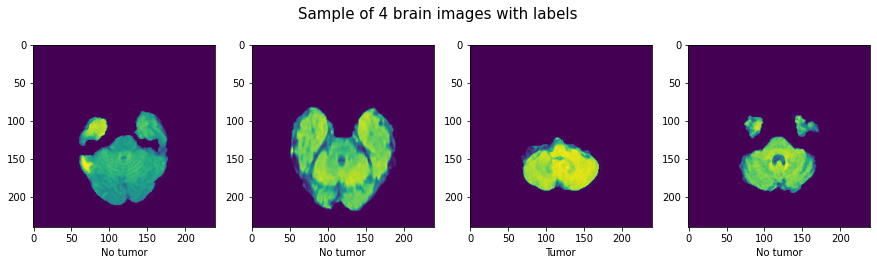

In [8]:
random_img = np.random.randint(1,nbr_images,4)
plt.figure(figsize=(15,4))
plt.suptitle('Sample of 4 brain images with labels', y=0.95,fontsize=15)
for i in range(len(random_img)):
    image_temp = Image.open('../Images/Image'+ str(random_img[i]) +'.jpg').convert('L')  # Conversion to Black & White
    plt.subplot(1,4,i+1)
    plt.imshow(image_temp)
    if df.iloc[random_img[i],1] == 0:
        plt.xlabel('No tumor')
    else:
        plt.xlabel('Tumor')

In [9]:
print('Total number of images:', nbr_images)

Total number of images: 3762


In [10]:
sample = np.asarray(Image.open('../Images/Image1.jpg').convert('L'))
print('Image shape:',sample.shape)

Image shape: (240, 240)


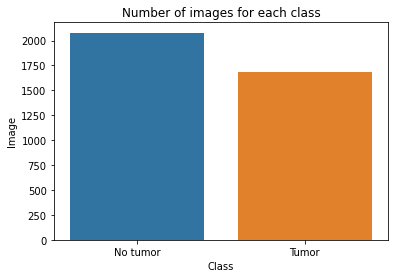

In [11]:
temp_df = df.groupby('Class').count()
temp_df.reset_index(inplace=True)
temp_df.iloc[0,0]='No tumor'
temp_df.iloc[1,0]='Tumor'
sb.barplot(data = temp_df, x='Class', y='Image')
plt.title('Number of images for each class');

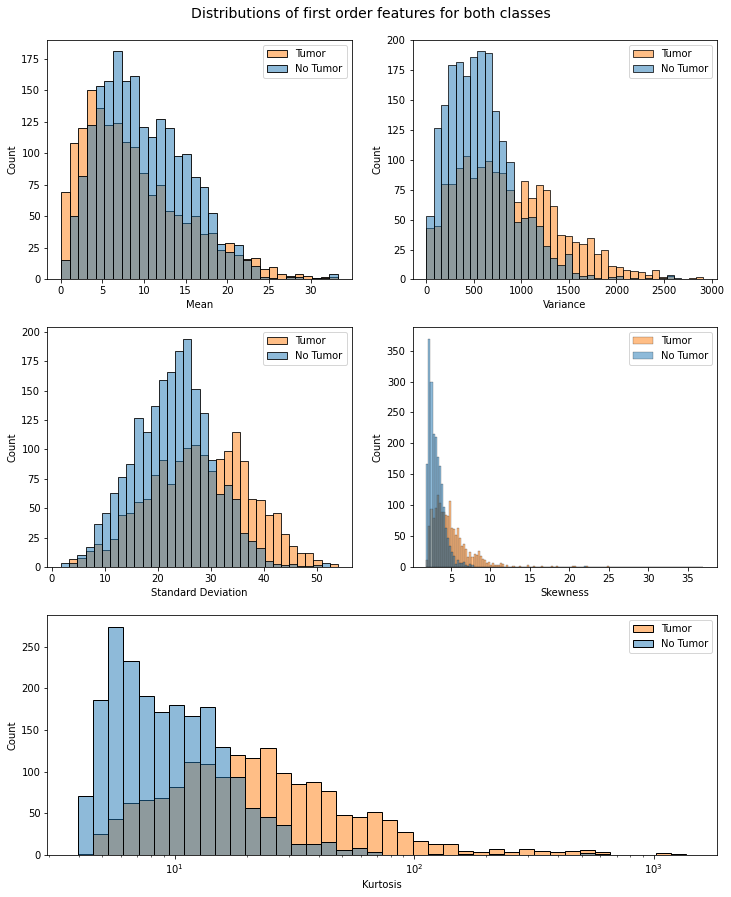

In [12]:
plt.figure(figsize=(12,15))
plt.suptitle('Distributions of first order features for both classes', fontsize=14, y=0.91)
plt.subplot(3,2,1)
sb.histplot(data = df, x = 'Mean', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,2,2)
sb.histplot(data = df, x = 'Variance', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,2,3)
sb.histplot(data = df, x = 'Standard Deviation', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,2,4)
sb.histplot(data = df, x = 'Skewness', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,1,3)
sb.histplot(data = df, x = 'Kurtosis',  log_scale=True, hue = 'Class')
plt.legend(['Tumor','No Tumor']);

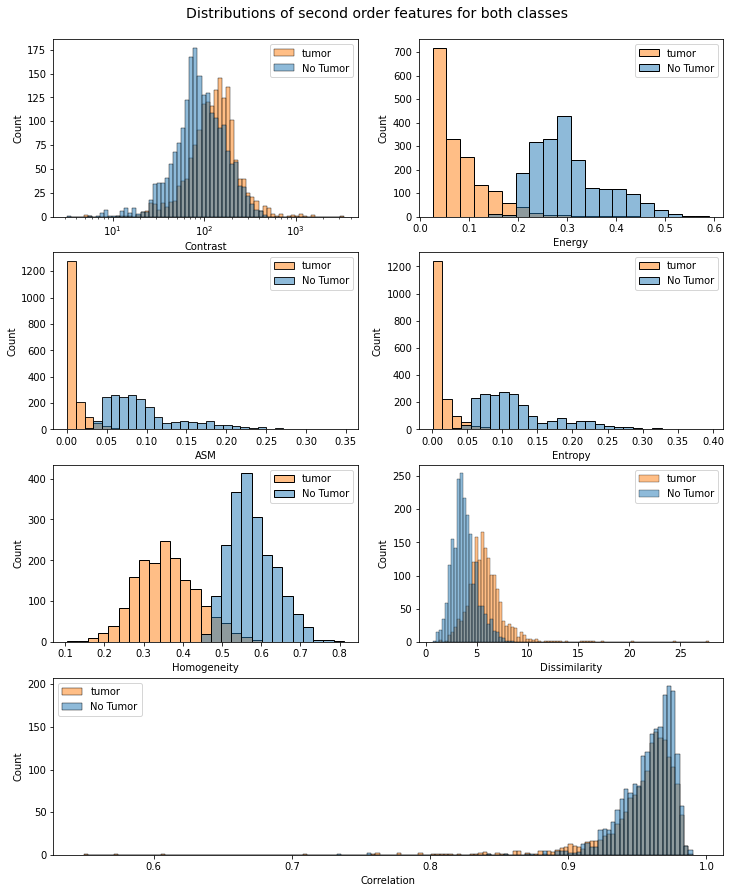

In [13]:
plt.figure(figsize=(12,15))
plt.suptitle('Distributions of second order features for both classes', fontsize=14, y=0.91)
plt.subplot(4,2,1)
sb.histplot(data = df, x = 'Contrast', log_scale=True, hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,2)
sb.histplot(data = df, x = 'Energy', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,3)
sb.histplot(data = df, x = 'ASM', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,4)
sb.histplot(data = df, x = 'Entropy', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,5)
sb.histplot(data = df, x = 'Homogeneity', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,6)
sb.histplot(data = df, x = 'Dissimilarity', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,1,4)
sb.histplot(data = df, x = 'Correlation', hue = 'Class')
plt.legend(['tumor','No Tumor']);

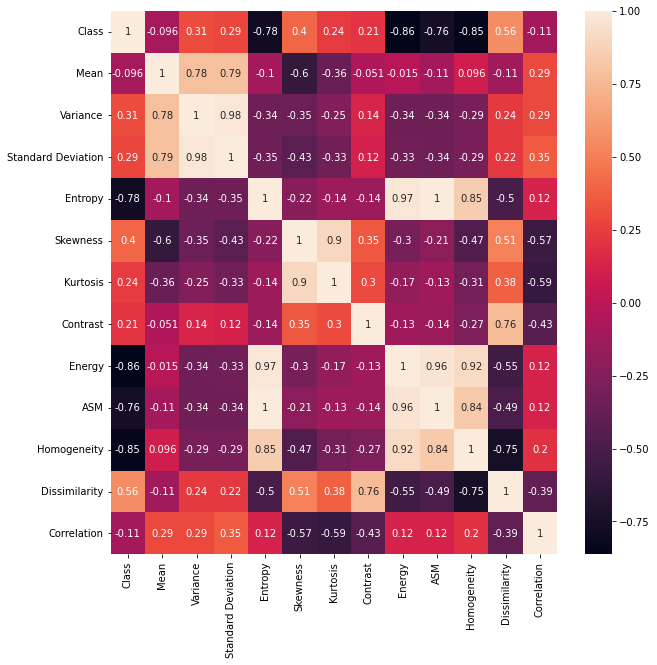

In [14]:
plt.figure(figsize=(10,10))
sb.heatmap(df.iloc[:,1:df.shape[1]-1].corr(), annot=True);

In [15]:
def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std
    return data_normalized

In [16]:
def initialize_weights_bias(layer_dims):
    L = len(layer_dims)                     
    params = {}
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/(layer_dims[l-1]+layer_dims[l]))
        params['b' + str(l)] = np.zeros((1, layer_dims[l]))
    return params

In [17]:
def activation(activation_types, Z):
    if (activation_types == 'sigmoid'):
        s = 1/(1+np.exp(-Z))
    else:
        s = np.maximum(np.zeros(Z.shape), Z)  # Z must be np.array
    return s

In [18]:
def activation_derivative(activation_types, Z):
    if (activation_types == 'sigmoid'):
        s = np.multiply(activation('sigmoid', Z),(1 - activation('sigmoid', Z)))
    else:
        s = np.maximum(np.zeros(Z.shape), Z)
        s[s!=0] = 1
    return s

In [19]:
def forward_pass(X, params, layer_dims, activation_types):
    L = len(layer_dims)
    cache={}
    A = X
    cache['A0'] = X
    for l in range(1, L):
        Z = np.dot(A,params['W' + str(l)].T) + params['b' + str(l)]
        A = activation(activation_types[l-1], Z)
        cache['Z' + str(l)] = Z
        cache['A' + str(l)] = A
    return A, cache

In [20]:
def cross_entropy_cost(Yhat, Y, params, lamda):
    m = Y.shape[0]
    L = int(len(params)/2)
    L2_reg = 0
    for l in range(1,L+1):
        L2_reg += np.linalg.norm(params['W' + str(l)])**2
    cost = -(1/m)*(np.dot(np.log(Yhat.T),Y)+np.dot(np.log(1-Yhat.T),(1-Y))) + (lamda/(2*m))*L2_reg
    cost = np.squeeze(cost)
    return cost

In [21]:
def back_prop(Y, Yhat, cache, params, activation_types, lamda):
    grads = {}
    L = int(len(cache)/2)+1
    dYhat = - (np.divide(Y, Yhat) - np.divide(1 - Y, 1 - Yhat))
    m = Y.shape[0]
    for l in reversed(range(1,L)):
        dZ = np.multiply(dYhat, activation_derivative(activation_types[l-1], cache['Z'+str(l)]))
        dW = (1/m)*np.dot(dZ.T, cache['A'+str(l-1)]) + (lamda/m)*params['W' + str(l)]
        db = (1/m)*np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, params['W'+str(l)])                 
        dYhat = dA_prev
        grads["dA" + str(l-1)] = dA_prev
        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db
        assert (dW.shape == params['W'+str(l)].shape)
        assert (db.shape == params['b'+str(l)].shape)
    return grads

In [22]:
def update_parameters(parameters, grads, learning_rate, L):
    for l in range(1,L):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

In [29]:
def model(X_train,X_val,X_test,Y_train,Y_val,Y_test, model_config):
    
    i=0
    conv = 1
    cost_history={
        'Train_loss': [],
        'Val_loss': []
    }
    
    learning_rate = model_config['learning_rate']
    lamda = model_config['lamda']
    layer_dims = model_config['layer_dims']
    activation_types = model_config['activation_types']
    max_iter = model_config['max_iter']
    params = initialize_weights_bias(layer_dims)
    L = len(layer_dims)
    
    toolbar_width = 20
    sys.stdout.write("[%s]" % ("" * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
    start = time.time()
    
    while (i<max_iter)&(conv>10e-7):
        Yhat, cache = forward_pass(X_train, params, layer_dims, activation_types)
        Yhat_val, _ = forward_pass(X_val, params, layer_dims, activation_types)
        cost_train = cross_entropy_cost(Yhat, Y_train, params, lamda)
        cost_val = cross_entropy_cost(Yhat_val, Y_val, params, lamda)
        
        grads = back_prop(Y_train, Yhat, cache, params, activation_types, lamda)
        params = update_parameters(params, grads, learning_rate, L)
        
        cost_history['Train_loss'].append(cost_train)
        cost_history['Val_loss'].append(cost_val)
        
        if i>2:
            conv = np.abs(cost_history['Train_loss'][-1]-cost_history['Train_loss'][-2])
        i+=1
        if i%100==0:
            sys.stdout.write("=")
            sys.stdout.flush()
    sys.stdout.write("]\n") # this ends the progress bar
    
    end = time.time()
    training_dur = end-start
    train_accuracy = accuracy_score(Y_train, np.round(Yhat))
    
    Yhat_test, _ = forward_pass(X_test, params, layer_dims, activation_types)
    test_accuracy = accuracy_score(Y_test, np.round(Yhat_test))
    conf_matrix = confusion_matrix(Y_test, np.round(Yhat_test), normalize='true')
    
    F1_score = f1_score(Y_test, np.round(Yhat_test))
    
    Model_infos={
        'Train_acc': train_accuracy,
        'Test_acc': test_accuracy,
        'conf_matrix': conf_matrix,
        'Train_dur': training_dur,
        'F1_score': F1_score
    }
    return cost_history, params, Model_infos

In [30]:
def GridSearch(learning_rates, lamdas, model_config):
    best_F1 = 0
    results = {}
    models_cost_history = []
    models_params = []
    Best_model = {}
    m=1
    print('-------------- Beginning of Grid Search --------------')
    print('------------------ Training Models -------------------')
    for i in range(len(learning_rates)):
        for j in range(len(lamdas)):
            model_config['learning_rate'] = learning_rates[i]
            model_config['lamda'] = lamdas[j]
            print('Training of Model '+str(m)+' (Learning rate: '+str(learning_rates[i]) + ' Lambda: ' + str(lamdas[j])+')' )
            cost_history, params, Model_infos = model(X_train_img,X_val_img,X_test_img,Y_train,Y_val,Y_test, model_config)
            print('Training duration: ' + str(Model_infos['Train_dur']/60)  + 'min')
            print('Number of epochs: ' + str(int(len(cost_history['Train_loss']))))
            print('Train accuracy: ' + str(Model_infos['Train_acc']) + ' | ' + 'Test accuracy: ' +
                  str(Model_infos['Test_acc'])+ ' | ' + 'F1 score: ' + str(Model_infos['F1_score']))
            results['Model: '+ str(learning_rates[i]) + ' ' + str(lamdas[j])] = Model_infos
            models_cost_history.append(cost_history)
            if Model_infos['F1_score']>best_F1:
                best_F1 = Model_infos['F1_score']
                Best_model['infos'] = Model_infos
                Best_model['cost_history'] = cost_history
                Best_model['params'] = params  
                Best_model['hyperparams'] = (learning_rates[i],lamdas[j])
            m+=1
            print('')
    print('--------------------- Best Model ---------------------')
    print('Best F1 score: ' + str(Best_model['infos']['F1_score']))
    print('Best hyper-parameters: Learning rate: ' + str(Best_model['hyperparams'][0]) + ' ' +
          'Lambda: '+ str(Best_model['hyperparams'][1]))
    print('----------------- End of Grid Search -----------------')
    return results, models_cost_history, Best_model

In [31]:
labels = np.array(df.iloc[:,1])

In [32]:
data = df.iloc[:,2:]
Data_normalized = scale(data)

In [33]:
Data_normalized_df = pd.DataFrame(Data_normalized)
images_df = pd.DataFrame(df.iloc[:,0:1])
master_data_df = pd.concat([images_df, Data_normalized_df], axis=1)
master_data_df.head()

,Image,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Image1,-0.515700,-0.195790,-0.033144,0.504650,0.067855,-0.097267,-0.268050,0.685118,0.470073,0.404100,-0.121709,1.000713,0.0
1,Image2,-0.129018,0.202943,0.365594,2.746050,-0.150204,-0.175881,-0.585492,2.090287,2.865580,1.345457,-0.799181,1.264377,0.0
2,Image3,-0.375013,0.925765,0.984680,-1.026708,0.374531,0.037048,-0.421010,-1.335981,-0.988340,-1.649391,0.693704,0.850636,0.0
3,Image4,-0.616481,0.531896,0.660820,-1.026561,0.615188,0.160202,0.212525,-1.335154,-0.988223,-1.840334,1.622995,0.322041,0.0
4,Image5,-0.379529,0.039451,0.208352,1.041256,0.070489,-0.094103,0.429532,1.075849,1.022442,0.171115,1.154744,0.650854,0.0


In [34]:
np.random.seed(7)
X_train, X_test, Y_train, Y_test = train_test_split(master_data_df, labels, test_size=0.20, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=7)

Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_val = Y_val.reshape(Y_val.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)

In [37]:
def image_feat_separator(data):
    images_names_list = list(data.iloc[:,0])
    feat_df = data.iloc[:,1:]
    path_list=[]
    images_list=[]
    for i in images_names_list:
        path = "../Images/"+i+".jpg"
        path_list.append(path)
    for i in path_list:
        temp = Image.open(i).convert('L')
        array_temp = np.asarray(temp)
        max_pooling_temp = skimage.measure.block_reduce(array_temp, (2,2), np.max)
        flat_temp = list(max_pooling_temp.flatten())
        images_list.append(flat_temp)
        temp.close()
    images_array = np.array(images_list)
    return images_array, feat_df

In [38]:
X_train_img, X_train_feat = image_feat_separator(X_train)
X_test_img, X_test_feat = image_feat_separator(X_test)
X_val_img, X_val_feat = image_feat_separator(X_val)

In [39]:
print('The train image set shape:', X_train_img.shape)
print('The test image set shape:', X_test_img.shape)
print('The validation image set shape:', X_val_img.shape)

The train image set shape: (2708, 14400)
The test image set shape: (753, 14400)
The validation image set shape: (301, 14400)


In [40]:
X_train_img = normalize(X_train_img)
X_test_img = normalize(X_test_img)
X_val_img = normalize(X_val_img)

In [41]:
model_config={
    'layer_dims' : [X_train_img.shape[1],8,8,8,4,1],
    'activation_types' : ['ReLu','ReLu','ReLu','ReLu','sigmoid'],
    'max_iter' : 10000
}

In [42]:
# Executing the Grid Search function / Training MLP models
Start_timer = time.time()
learning_rates = list(np.random.uniform(0.0001,0.001,3))
lamdas = list(np.random.uniform(1,2,3))
results, models_cost_history, Best_model = GridSearch(learning_rates, lamdas, model_config)
Stop_timer = time.time()
GridSearch_dur = Stop_timer - Start_timer
print('Grid search training duration: ', GridSearch_dur/60, ' min')

-------------- Beginning of Grid Search --------------
------------------ Training Models -------------------
Training of Model 1 (Learning rate: 0.00016867746043656146 Lambda: 1.723465177830941)
[====================================================================================================]
Training duration: 31.98669785261154min
Number of epochs: 10000
Train accuracy: 0.8242245199409158 | Test accuracy: 0.8047808764940239 | F1 score: 0.780269058295964

Training of Model 2 (Learning rate: 0.00016867746043656146 Lambda: 1.9779895119966027)
[====================================================================================================]
Training duration: 30.812392214934032min
Number of epochs: 10000
Train accuracy: 0.803175775480059 | Test accuracy: 0.7888446215139442 | F1 score: 0.767883211678832

Training of Model 3 (Learning rate: 0.00016867746043656146 Lambda: 1.5384958704104337)
[===========================================================================================

In [43]:
with open('GSresults', 'wb') as f:
    pickle.dump([results, models_cost_history, Best_model], f)

In [33]:
# Use this if you have a model to load.

#with open('GSresults', 'rb') as f:
#    results, models_cost_history, Best_model = pickle.load(f)

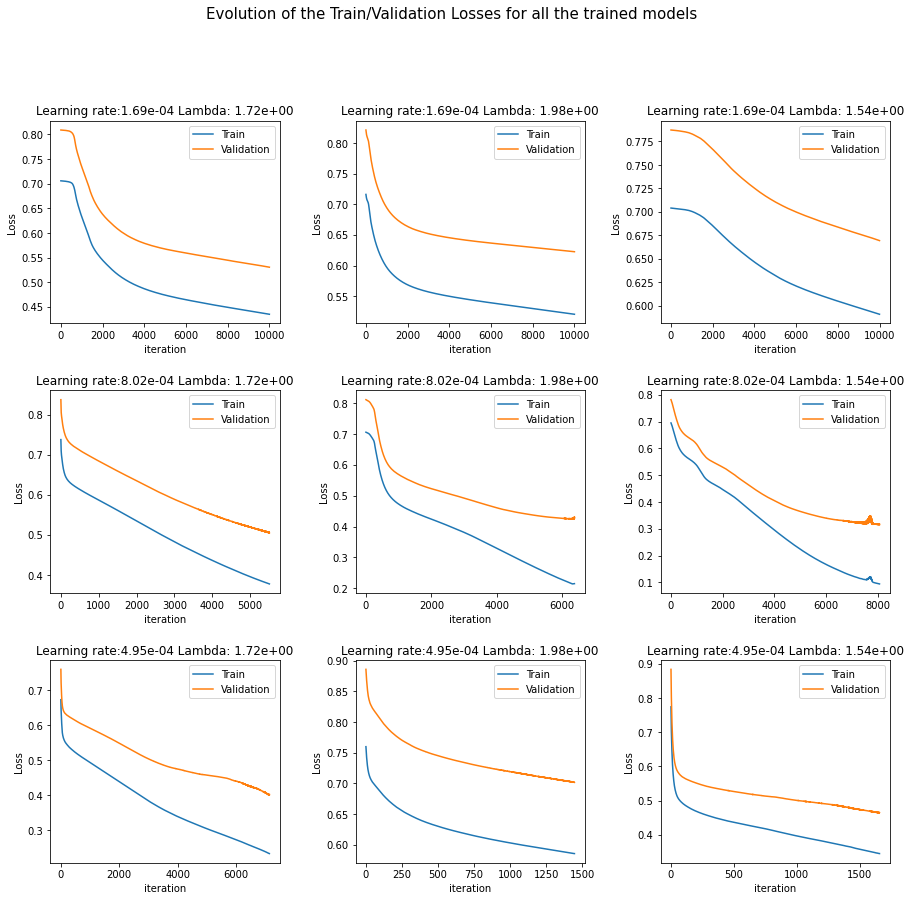

In [44]:
figure = plt.figure(figsize=(min(len(learning_rates)*4.3,15),min(len(lamdas)*4,15)))
plt.suptitle('Evolution of the Train/Validation Losses for all the trained models',fontsize=15, y=1.05)
nbr_plots = len(learning_rates)*len(lamdas)
alpha_lamda_combinations = [(i,j) for i in learning_rates for j in lamdas]
for i in range(1,nbr_plots+1):
    plt.subplot(len(learning_rates),len(lamdas),i)
    x = list(range(0,len(models_cost_history[i-1]['Train_loss'])))
    y1 = list(np.squeeze( models_cost_history[i-1]['Train_loss']))
    y2 = list(np.squeeze( models_cost_history[i-1]['Val_loss'])) 
    temp_df = pd.DataFrame([x,y1,y2]).T
    temp_df.columns=['x','y1','y2']
    sb.lineplot(data=temp_df, x='x', y='y1')
    sb.lineplot(data=temp_df, x='x', y='y2')
    plt.title('Learning rate:' + str("{:.2e}".format(alpha_lamda_combinations[i-1][0])) + ' Lambda: ' + str("{:.2e}".format(alpha_lamda_combinations[i-1][1])))
    plt.legend(['Train','Validation'])
    plt.xlabel('iteration')
    plt.ylabel('Loss') 
figure.tight_layout(pad=2.0);

In [45]:
def plot_cm(mat,y_ture,ax):
    df_cm = pd.DataFrame(mat, columns=np.unique(y_ture), index = np.unique(y_ture))
    df_cm.index.name = 'True Label'
    df_cm.columns.name = 'Predicted Label'
    sb.heatmap(df_cm, cmap="Blues", cbar=False, annot=True,annot_kws={"size": 10}, ax=ax)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

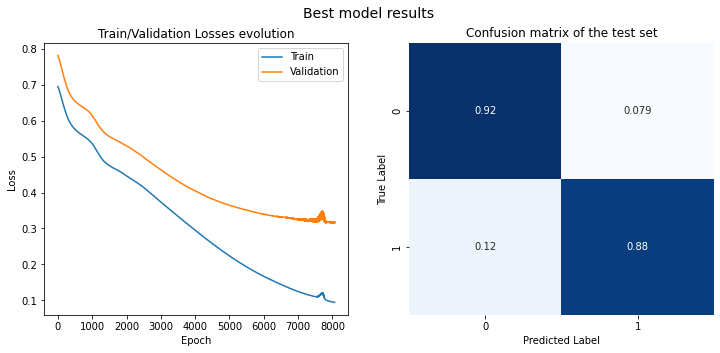

In [46]:
plt.figure(figsize=(12,5))
plt.suptitle('Best model results', fontsize=14)
ax1 = plt.subplot(1,2,1)
plt.title('Train/Validation Losses evolution')
x = list(range(0,len(Best_model['cost_history']['Train_loss'])))
y1 = list(np.squeeze( Best_model['cost_history']['Train_loss']))
y2 = list(np.squeeze( Best_model['cost_history']['Val_loss'])) 
temp_df = pd.DataFrame([x,y1,y2]).T
temp_df.columns=['x','y1','y2']
sb.lineplot(data=temp_df, x='x', y='y1')
sb.lineplot(data=temp_df, x='x', y='y2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
ax2 = plt.subplot(1,2,2)
plt.title('Confusion matrix of the test set')
plot_cm(Best_model['infos']['conf_matrix'], Y_test, ax2);

In [47]:
print('The best grid search model results:')

result_table=[['Train accuracy', Best_model['infos']['Train_acc']],
             ['Test accuracy', Best_model['infos']['Test_acc']],
             ['F1 score', Best_model['infos']['F1_score']],
             ['Training duration', Best_model['infos']['Train_dur']/60]]

display(HTML(tabulate.tabulate(result_table, colalign=("center","center"), tablefmt='html')))

The best grid search model results:


Train accuracy,0.983013
Test accuracy,0.900398
F1 score,0.886878
Training duration,191.342


In [48]:
def xgb_GS(data, nbr_estimators, max_depth, learning_rate):
    X_train_feat = data['X_train_feat']
    X_val_feat = data['X_val_feat']
    X_test_feat = data['X_test_feat']
    Y_train = data['Y_train']
    Y_val = data['Y_val']
    Y_test = data['Y_test']
    best_f1 = 0
    for i in learning_rate:
        for j in max_depth:
            for k in nbr_estimators:
                xgb_model = xgb.XGBClassifier(n_estimators=k, max_depth=j, learning_rate=i)
                xgb_model.fit(X_train_feat, Y_train, verbose=False)
                Yhat_xgb = xgb_model.predict(X_test_feat)
                Yhat_xgb = np.round(Yhat_xgb.reshape(Y_test.shape[0],1))
                score = f1_score(Y_test, Yhat_xgb)
                if score > best_f1:
                    best_f1 = score
                    best_hyper_params=[k,j,i]
    return best_f1, best_hyper_params

In [49]:
data={
    'X_train_feat': X_train_feat,
    'X_val_feat': X_val_feat,
    'X_test_feat': X_test_feat,
    'Y_train': Y_train,
    'Y_val': Y_val,
    'Y_test': Y_test
}
nbr_estimators = [5,10,15,20,25]
max_depth = [4,8,16]
learning_rate = [0.1, 0.2, 0.4, 0.6, 0.8]

In [50]:
best_f1, best_hyper_params = xgb_GS(data, nbr_estimators, max_depth, learning_rate);

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

In [51]:
print('The best grid search model results:')

result_table=[['Number of estimators', best_hyper_params[0]],
             ['Max_depth', best_hyper_params[1]],
             ['Learning_rate', best_hyper_params[2]],
             ['F1 score', best_f1]]

display(HTML(tabulate.tabulate(result_table, colalign=("center","center"), tablefmt='html')))

The best grid search model results:


Number of estimators,20
Max_depth,16
Learning_rate,0.8
F1 score,0.986466


In [52]:
start=time.time()
xgb_BM = xgb.XGBClassifier(n_estimators=best_hyper_params[0], max_depth=best_hyper_params[1],
                                     learning_rate=best_hyper_params[2])
eval_set=[(X_train_feat, Y_train), (X_val_feat, Y_val)]
xgb_BM.fit(X_train_feat, Y_train, eval_metric=['logloss','rmse','error'], eval_set=eval_set, verbose=False)
end=time.time()
duration_xgb = end-start
Yhat_xgb_BM = xgb_BM.predict(X_test_feat)
Yhat_xgb_BM = np.round(Yhat_xgb_BM.reshape(Y_test.shape[0],1))

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

In [53]:
results = xgb_BM.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

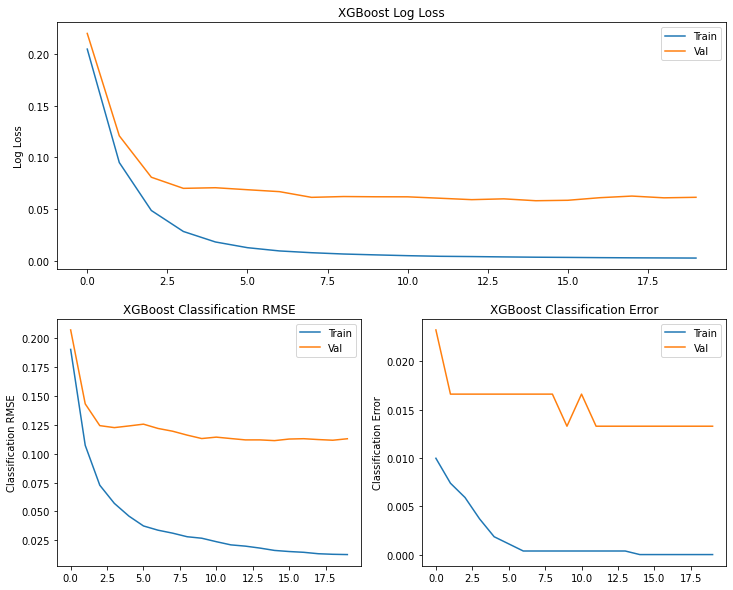

In [54]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Val')
plt.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')

plt.subplot(2,2,3)
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Val')
plt.legend()
plt.ylabel('Classification RMSE')
plt.title('XGBoost Classification RMSE')

plt.subplot(2,2,4)
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Val')
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error');

In [55]:
print('The best grid search model results:')

result_table=[['Test accuracy', accuracy_score(Yhat_xgb_BM, Y_test)],
             ['F1 score', f1_score(Yhat_xgb_BM, Y_test)],
             ['Training duration', duration_xgb]]

display(HTML(tabulate.tabulate(result_table, colalign=("center","center"), tablefmt='html')))

The best grid search model results:


Test accuracy,0.988048
F1 score,0.986466
Training duration,0.0510459


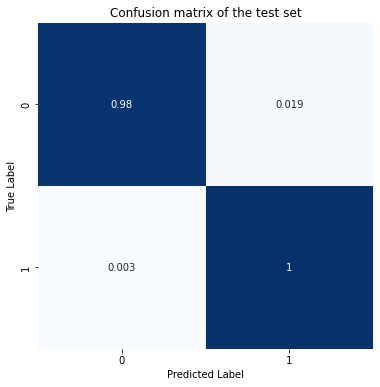

In [56]:
plt.figure(figsize=(6,6))
ax1 = plt.subplot(111)
plt.title('Confusion matrix of the test set')
plot_cm(confusion_matrix(Yhat_xgb_BM, Y_test, normalize='true'), Y_test, ax1);